# Analysis and Interpretation of PalWorld Data
#### Team Group Number: 8
- Kerbs Downing
- Owen Sharpe

In [21]:
# Put all the module import in this code chunk
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np
from copy import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Introduction

Let's first start by introducing the idea of PalWorld. This multiplayer, open world survival game echoes similarities to Pokémon with its usage of trained companions who fight alongside you. Given that these companions, known as Pals, have so many unique characteristics, one can see how there are many different ways to conduct analysis on them.

Each Pal contains specific features. Here are generally most of those features: name, rarity, level, element type, abilities, combat power, average attack, defense, health points, average speed, stamina, price. There are a couple other features which we have decided not to conduct research on, but are still relatively impactful on deciding the uniqueness of a Pal. When doing an analysis on these Pals, we can possibly find important conclusions and visualizations which can provide gameplay advantages. 

## Research Question

Getting more specific, we can create research questions which will lead us to uncovering some trends we find in the data. Here are two of these questions:

1. Are There Distinctions/Advantages to Certain Pal Element Types?
2. Do Certain Features (i.e. price, rarity, health points) impact a Pals combat power?

## Data 

### Data Source

We scraped our data from https://palworld.gg/pals.

From this website, for each pal (164 in total) we scraped the following features:
- Name
- Rarity
- Level
- Element Type
- Abilities
- Combat Power (CP)
- Average Attack
- Defense
- Health Points (HP)
- Average Speed
- Stamina
- Price

[(Here's a link to an example for a singular pal)](https://palworld.gg/pal/frostallion-noct)

We really didn't have to clean anything specifically because the data online is formatted nicely. We scraped everything into a dataframe and then exported it as a CSV file titled `palworld.csv`. From here, the data can be used and processed with the pandas module.

### Webscraping and cleaning functions overview

- `get_pal_names(url)`
    - This function scrapes names from the pal-world database.
- `get_pal_data(name)`    
    - This function scrapes the required features for an individual pal.
- `create_pal_dataframe(pal_names)`
    - This function creates a dataframe containing specific data for each pal.

### Data overview

Here's a sample of our dataframe:

In [22]:
pals_df = pd.read_csv('palworld.csv')
pals_df.head()

,Name,Rarity,Level,Element Type,Abilities,CP,Avg. Attack,Defense,HP,Avg. Speed,Stamina,Price
0,Anubis,Epic,10,Earth,"[{'name': 'Stone Blast', 'level': 1, 'power': ...",350.0,130.0,100,120,626.666667,100,4960
1,Arsox,Common,4,Fire,"[{'name': 'Ignis Blast', 'level': 1, 'power': ...",277.5,97.5,95,85,495.666667,100,3520
2,Astegon,Epic,9,DragonDark,"[{'name': 'Dragon Cannon', 'level': 1, 'power'...",337.5,112.5,125,100,500.000000,300,8200
3,Azurobe,Rare,7,WaterDragon,"[{'name': 'Aqua Gun', 'level': 1, 'power': 40,...",295.0,85.0,100,110,491.666667,100,5600
4,Beakon,Rare,6,Electricity,"[{'name': 'Air Cannon', 'level': 1, 'power': 2...",292.5,107.5,80,105,683.333333,160,7490


We are most likely going to use all of these features in some regard. I wouldn't say we have a specific target value, but we may use combat power and element type (ice, dark, dragon, earth leaf, electricity, water, fire, normal) at some point. The other features go without saying, as their names generally address what their feature is; each Pal has a name, rarity (common, rare, epic, legendary), level (1-20), abilities (or skills), average attack, defense, hp (health points), average speed, stamina, and price.

We cleaned up any missing values previously in the data scraping section, so there are no issues in the dataframe. There are some other skills known as 'partner skills' which we did not collect; those maybe could be useful in certain analysis scenarios. But overall, we generally had no concerns with our data.

## Webscraping and cleaning

##### Here Are The Functions We Have Written for Data Scraping and Preprocessing

In [23]:
def get_pal_names(url):
    """ scrapes names from the pal-world database and creates a list of names
    
    Args:
        url (str): an url 
        
    Returns:
        pal_names (list): a list containing the name of each pal
    """
    
    # get the html contents 
    feed = requests.get(url)
    html = feed.text
    
    # use beautiful soup to parse the html file
    palwrld_soup = BeautifulSoup(html)
    
    # get the pal list
    pals = palwrld_soup.find('section', class_="pals-list").find_all('div', class_='container')
    
    # now for each pal, add the name to a list
    pal_names = []
    for pal in pals:
        name_feed = pal.find('div', class_='name')
        name = re.sub(r'#\d+', '', name_feed.get_text(strip=True)).strip().replace('  ', ' ')
        
        # add to list
        pal_names.append(name)
    
    return pal_names


def get_pal_data(name):
    """ scrapes data for an individual pal
    
    Args:
        name (str): an individual pal name
        
    Returns:
        pal_data (list): a list containing some data of an individual pal
    """
    
    # construct the url - weird irregularity where 'Warsect Terra' demands two dashes
    if name == 'Warsect Terra':
        url = f'https://palworld.gg/pal/warsect--terra'
    elif len(name.split(' ')) == 2:
        fpart = name.lower().split(' ')[0]
        spart = name.lower().split(' ')[1]
        url = f'https://palworld.gg/pal/{fpart}-{spart}'
    else:
        url = f'https://palworld.gg/pal/{name.lower()}'
            
    # get the page html for the pal
    pal_feed = requests.get(url)
    pal_html = pal_feed.text
    
    # now use beautiful soup to get the data we want
    pal_soup = BeautifulSoup(pal_html)
    
    """
    we want to get the level, rarity, element type, number of abilities, avg attack, defense, 
    speed, health points, stamina, and combat power
    """
    
    # get level, rarity, and type
    level = int(pal_soup.find('div', class_='lv').get_text(strip=True))
    rarity = pal_soup.find('div', class_='rarity').find('div', class_='name').get_text(strip=True)
    element_type = pal_soup.find('div', class_='elements').get_text(strip=True)
    
    
    # get the pal's list of abilities (skills) - we're only going to find the active ones
    # if no active skills, just give 0
    abilities = []   
    active_skills = pal_soup.find('div', class_='active skills')
    if active_skills:
        
        skill_list = active_skills.find('div', class_='items').find_all('div', class_='item', recursive=False)
        
        for item in skill_list:
            # get the name, level and stats of each ability
            temp_ability = {'name': item.find('div', class_='name').get_text(strip=True),
                            'level': int(item.find('div', class_='level').get_text(strip=True).split(' ')[-1]),
                            'power': int(item.find('div', class_='red').find('div', class_='value').get_text(strip=True)),
                            'cooldown': int(
                            item.find('div', class_='yellow').find('div', class_='value').get_text(strip=True)),
                            'range': item.find('div', class_='grey').find('div', class_='value').get_text(strip=True)
                            }
            abilities.append(temp_ability)
        
    
    # we can go get avg attack, defense, avg speed, health points, stamina, price, and CP
    avg_attack = (float(pal_soup.find('div', class_='name', string='Melee Attack').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True)) + float(pal_soup.find('div', class_='name', string='Shot Attack').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True))) / 2
    
    defense = int(pal_soup.find('div', class_='name', string='Defense').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True))
    
    avg_speed = (float(pal_soup.find('div', class_='name', string='Running Speed').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True)) + float(pal_soup.find('div', class_='name', string='Sprinting Speed').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True)) + float(pal_soup.find('div', class_='name', string='Slow Walk Speed').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True))) / 3
    
    health_points = int(pal_soup.find('div', class_='name', string='HP').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True))
    stamina = int(pal_soup.find('div', class_='name', string='Stamina').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True))
    price = int(pal_soup.find('div', class_='name', string='Price').find_parent('div', class_='item').find('div', class_='value').get_text(strip=True))
    combat_power = avg_attack + defense + health_points
    
    # now assemble everything into a list
    pal_row = [name, rarity, level, element_type, abilities, combat_power, avg_attack,
               defense, health_points, avg_speed, stamina, price]
    
    return pal_row


def create_pal_dataframe(pal_names):
    """ creates a dataframe containing specific data for each pal
    
    Args:
        pal_names (str): a list of pal names
        
    Returns:
        pal_df (pandas dataframe): a dataframe containing data of all pals
    """
    
    pal_data = []
    for pal in pal_names:
        # get the data for the pal
        temp_data = get_pal_data(pal)
        
        # add to the overall data
        pal_data.append(temp_data)
    
    # create dataframe
    pal_df = pd.DataFrame(pal_data, columns=['Name', 'Rarity', 'Level', 'Element Type',
                                             'Abilities', 'CP', 'Avg. Attack',
                                             'Defense', 'HP', 'Avg. Speed',
                                             'Stamina', 'Price'])
    
    return pal_df

##### Here is The Code Which We Have Ran to Get Our CSV File

In [24]:
# code to get data
pal_list = get_pal_names('https://palworld.gg/pals')

# make dataframe
df = create_pal_dataframe(pal_list)

# save data as csv file
df.to_csv('palworld.csv', index=False)

## Visualizations

### Visualization functions overview

- `element_type_barp(df, feat)`
    - This function generates a bar plot looking at the average of certain features for each element type.
- `top_n_scatter_matrix(df, feat, n)`
    - This function generates a scatter plot matrix looking at the comparison of certain features and how they impact each other for the top n element types by count.
- `box_plot_element_type(df, features)`
    - This function generates a box plot looking at the comparison of certain feature distributions for each element type.
- `heat_map_corr(df, features)`
    - This function generates a heat map looking at the correlation between certain features.
 
### Visualization results

#### Visualization 1: Element Type Comparison Bar Plot

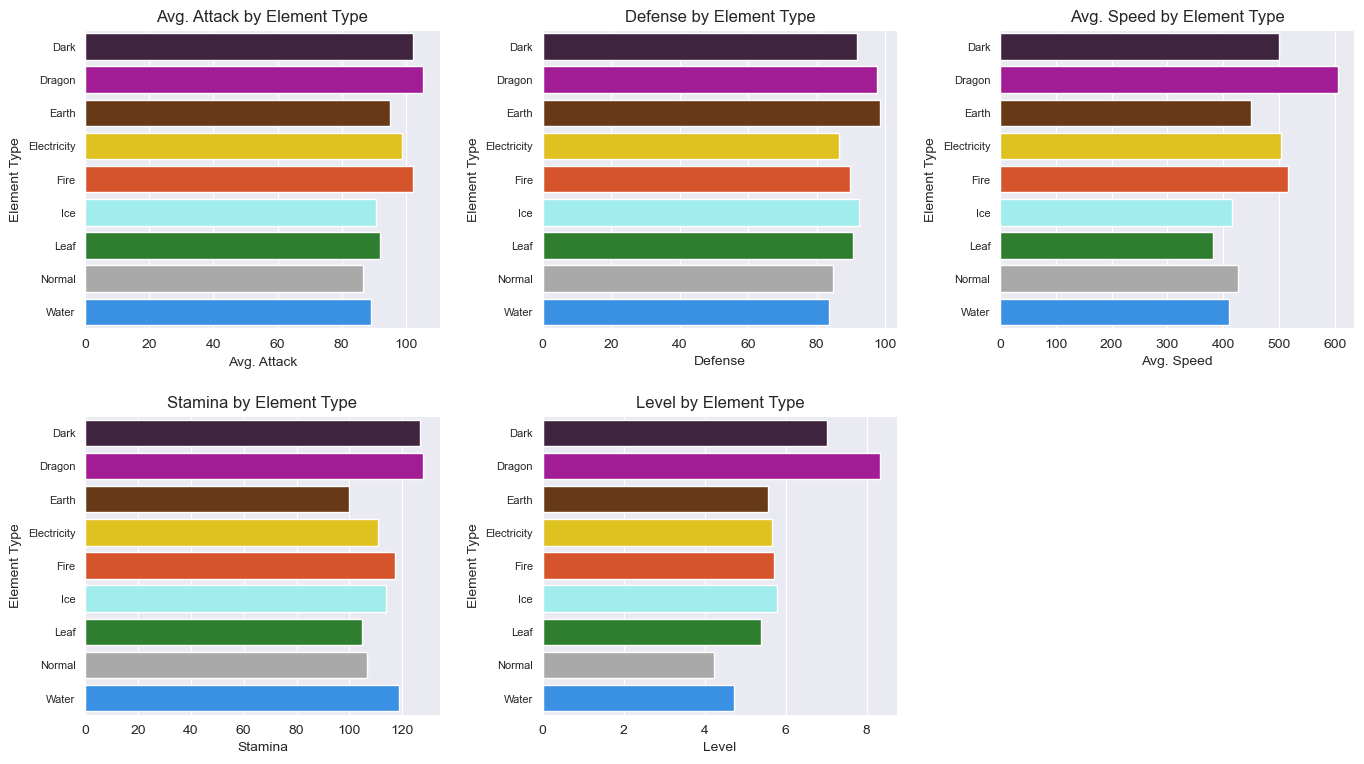

In [25]:
def element_type_barp(data_df, feat):
    """ creates a bar plot examining the average of certain features for each element type
    
    Args:
        data_df (pandas dataframe): a pandas dataframe of all the data for each pal
        feat (list): a list of Pal features to be compared 
        
    Returns:
        null: plotting
    """
    
    # split element types into separate rows
    df_expanded = data_df.assign(**{'Element Type': data_df['Element Type'].str.split(r'(?=[A-Z])')}).explode('Element Type')

    # filter the dataframe by the relevant element types
    ele_types = ['Earth', 'Fire', 'Dragon', 'Dark', 'Water', 'Electricity', 'Leaf', 'Normal', 'Ice']
    df_filtered = df_expanded[df_expanded['Element Type'].isin(ele_types)]

    # group by element type and calculate mean values for the selected columns
    avg_features = df_filtered.groupby('Element Type').mean().reset_index()
    
    # create a color dictionary
    color_dict = {'Earth': '#763709', 'Fire': '#F3450E', 'Dragon': '#B807A7',
                  'Dark': '#441F44', 'Water': '#1E90FF', 'Electricity': '#FFD700', 
                  'Leaf': '#228B22', 'Normal': '#A9A9A9', 'Ice': '#94F9F9'}

    # create a figure 
    plt.figure(figsize=(14, 8))

    # plotting
    for i, feature in enumerate(feat, 1):
        plt.subplot(2, 3, i)
        sns.barplot(y='Element Type', x=feature, data=avg_features,
                    width=.8, palette=color_dict)  
        plt.title(f'{feature} by Element Type')
        plt.xlabel(feature)
        plt.ylabel('Element Type')
        plt.tight_layout(pad=2.0)
        plt.rcParams['ytick.labelsize'] = 8

    plt.savefig('elementbars.png')
    plt.show()

# our features to compare
features = ['Avg. Attack', 'Defense', 'Avg. Speed', 'Stamina', 'Level']

# call the function
element_type_barp(pals_df, features)

##### Interpretation:
We can see that the dragon and dark element types tend to have better values than all other element types, excelling in the average speed, stamina, and level features. The average attack and defense features are a lot more balanced however, with most element types being fairly even. We can conclude however, that there are certainly advantages to dragon and dark element types.

#### Visualization 2: Scatter Plot Matrix of Certain Features

In [26]:
def top_n_scatter_matrix(data_df, feat, n):
    """ creates a scatter plot matrix examining the comparison and impact of certain features on each other for the top n element types by count
    
    Args:
        data_df (pandas dataframe): a pandas dataframe of all the data for each pal
        feat (list): a list of Pal features to be compared 
        n (int): top n number of element types (1-8)
        
    Returns:
        null: plotting
    """
    
    # split element types into separate rows
    df_expanded = data_df.assign(**{'Element Type': data_df['Element Type'].str.split(r'(?=[A-Z])')}).explode('Element Type')

    # replace values in dataframe by the relevant element types
    ele_types = ['Earth', 'Fire', 'Dragon', 'Dark', 'Water', 'Electricity', 'Leaf', 'Normal', 'Ice']
    df_filtered = df_expanded[df_expanded['Element Type'].isin(ele_types)]
    
    # get the top n most frequent element types
    top_n_df = df_filtered[df_filtered['Element Type'].isin(dict(df_filtered['Element Type'].value_counts()[:n]).keys())]
    
    # scatterplot matrix with plotly
    fig = px.scatter_matrix(top_n_df,
    dimensions=feat, hover_data={'Name': True, 'Level': True},
    labels={'CP': 'CP', 'HP': 'HP', 'Price': 'Price'}, title=f'Scatterplot Matrix of Pal Features for the {n} Most Frequent Element Types', color='Element Type')

    # update marker settings
    fig.update_traces(diagonal_visible=True)

    # show plot
    fig.write_image("scatter_matrix.png")
    fig.show()

# our features to compare
features = ['CP', 'HP', 'Price']

# call the function
top_n_scatter_matrix(pals_df, features, 3)

##### Interpretation:
Out of the six pairs, we can see that CP (x) and HP (y) are likely the most correlated values. Price (x) and CP (y) are another pair with a high correlation value. We can interpret that any pair of CP with HP or price will carry a high correlation value, while price and HP seem to be the pair with the lowest correlation.

#### Visualization 3: Box Plots of Certain Features by Element Type

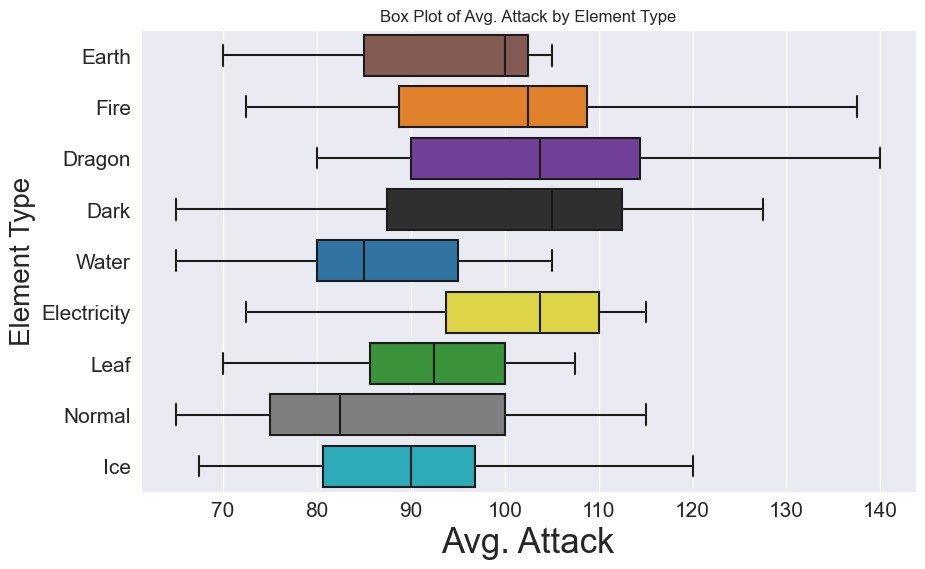

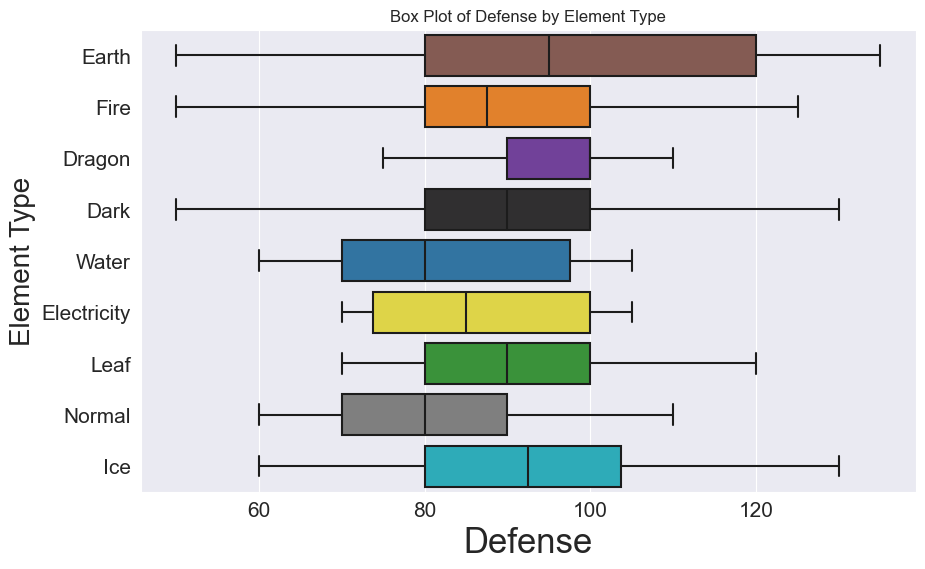

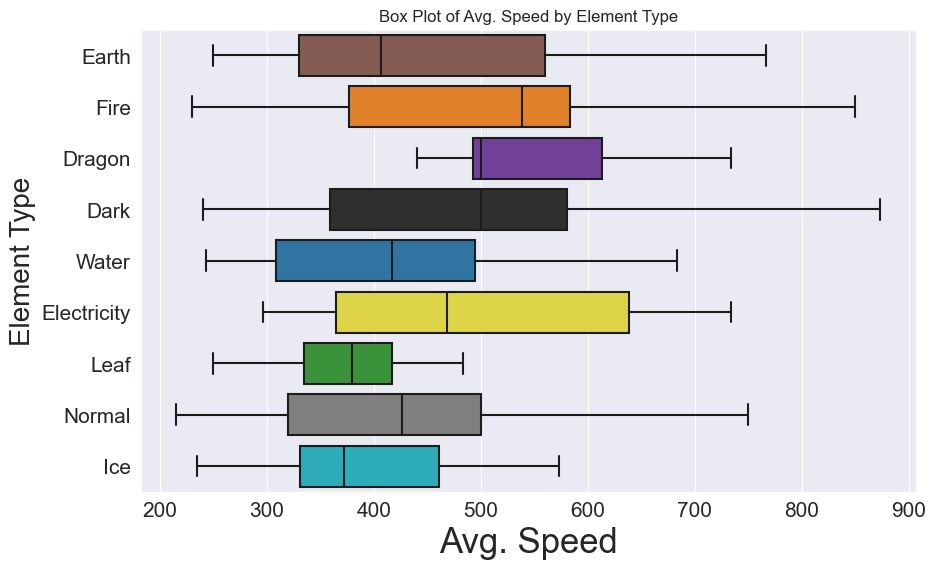

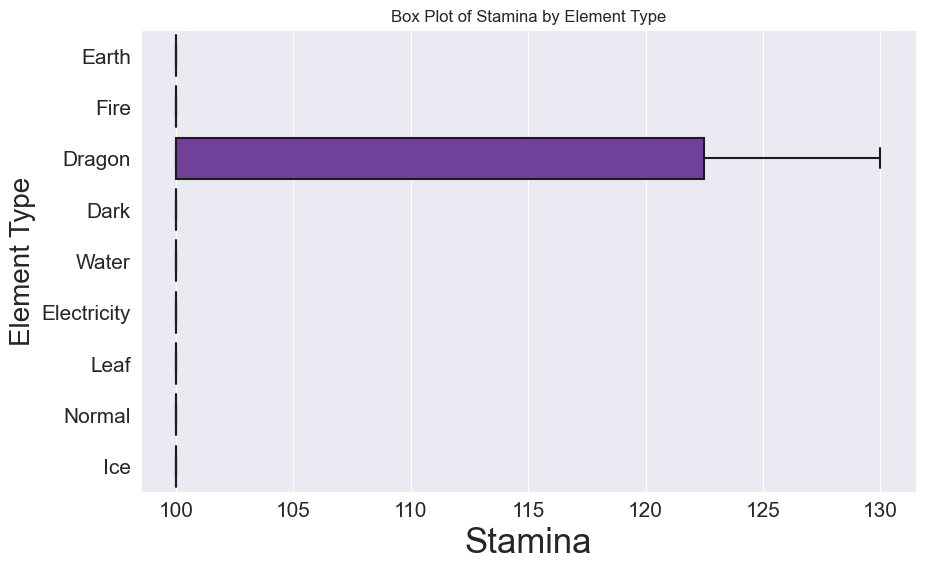

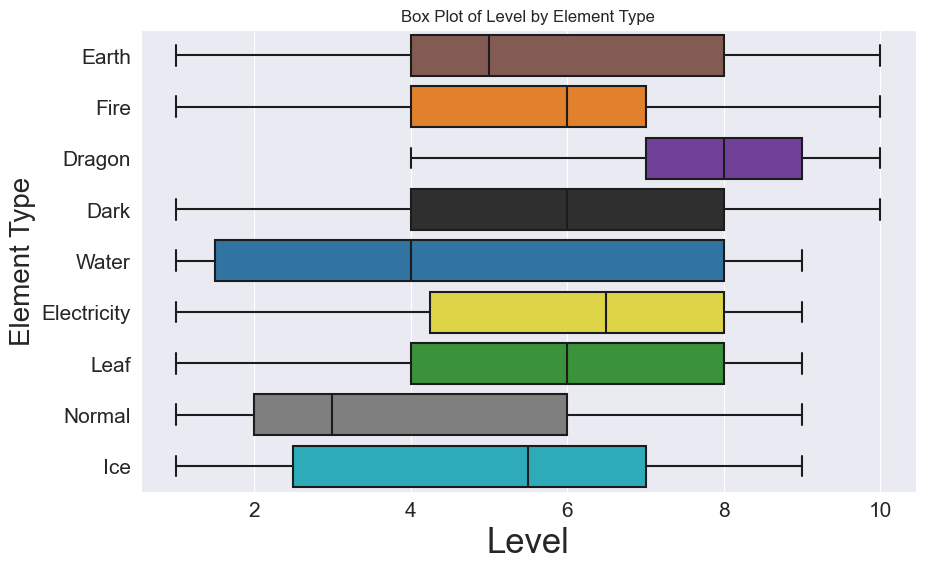

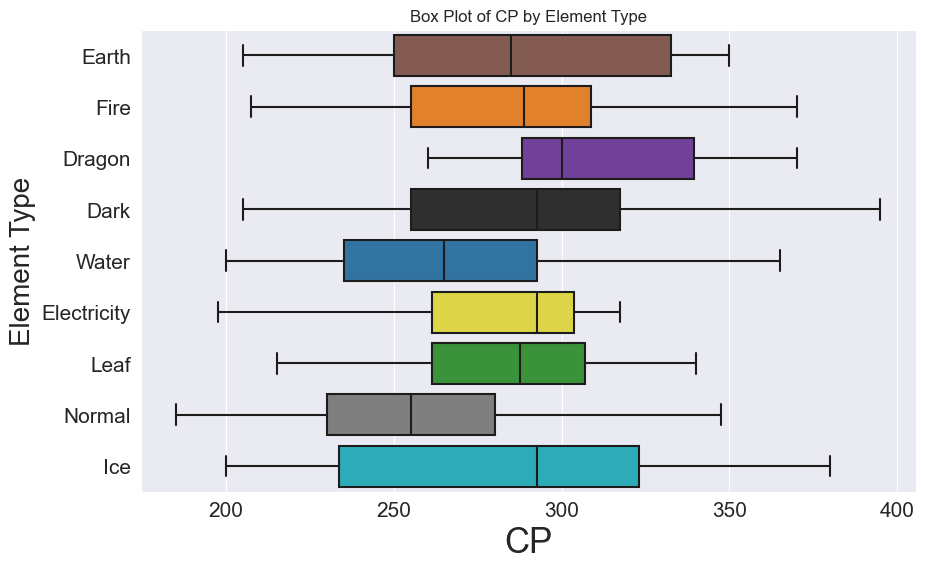

In [27]:
# re-filtering the dataframe
df_org = pals_df.assign(**{'Element Type': pals_df['Element Type'].str.split(r'(?=[A-Z])')}).explode('Element Type')
elTypes = ['Earth', 'Fire', 'Dragon', 'Dark', 'Water', 'Electricity', 'Leaf', 'Normal', 'Ice']
df_filtered = df_org[df_org['Element Type'].isin(elTypes)]


def box_plot_element_type(data_df, feats):
    """
    Generates box plots of the specified features, grouped by element type.
    
    Args:
        data_df (pandas dataframe): a pandas dataframe of all the data for each pal
        feats (list): a list of Pal features to be compared 
        
    Returns:
        null: plotting
    """
    #Visual dictionary
    palet = {
    'Earth': '#8c564b',        
    'Fire': '#ff7f0e',         
    'Dragon': '#7332a8',       
    'Dark': '#302f30',         
    'Water': '#1f77b4',        
    'Electricity': '#f7ea2f',  
    'Leaf': '#2ca02c',         
    'Normal': '#7f7f7f',       
    'Ice': '#17becf'            
    }
    #box plot for each feature
    for feat in feats:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=feat, y='Element Type', data=data_df, palette = palet, showfliers=False)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.title(f'Box Plot of {feat} by Element Type')
        plt.ylabel('Element Type', fontsize=20)
        plt.xlabel(feat, fontsize=25)
        #plt.savefig(f'box{feat}_final.png')
        plt.show()
     

# our features to compare
features = ['Avg. Attack', 'Defense','Avg. Speed', 'Stamina', 'Level', 'CP']
# call function
box_plot_element_type(df_filtered, features)

##### Interpretation:

Looking at these values, we can see that the Dragon and Dark element types typically have the highest medians and maximums. This would suggest that those element types are superior as they typically have higher values of each feature. Certain dragon and dark element varients maintain high median and max box values, but also a short box length, showing that there is not much variation, meaning these element variants are consistently having higher values than other element types. For example, Dragon's box in the defense graph does not have the highest median or max. Still, its box is significantly smaller than all the others, meaning it is more consistent in that range. In contrast, the other elements have a minimum much lower than the Dragon element types. 

#### Visualization 4: Heat Map of Certain Features

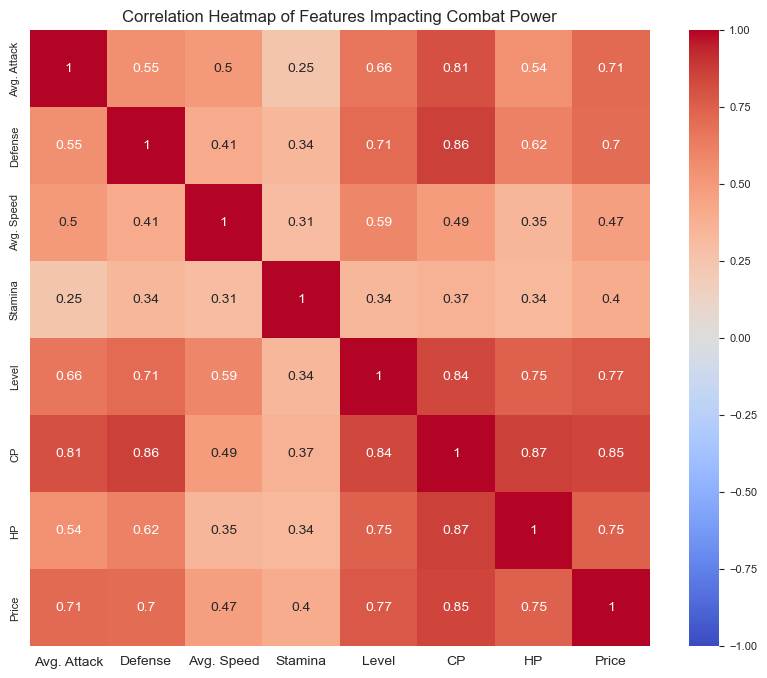

In [28]:
def heat_map_corr(data_df, feats):
    """
    Generates a heat map of the specified features.
    
    Args:
        data_df (pandas dataframe): a pandas dataframe of all the data for each pal
        feats (list): a list of Pal features to be compared to one another 
        
    Returns:
        null: plotting
    """

    # Calculate the correlation matrix
    corr_matrix = data_df[feats].corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Features Impacting Combat Power')
    #plt.savefig('heatm_final.png')
    plt.show()
    

# our features to compare
features = ['Avg. Attack', 'Defense','Avg. Speed', 'Stamina', 'Level', 'CP', 'HP', 'Price']
# call function
heat_map_corr(pals_df, features)

##### Interpretation:
We can see some of these values are very correlated with each other. 
Combat power looks to be most correlated with HP, Defense, Price, and Level. 
Stamina and Avg. Speed have the weakest correlation to all other features.
From this, speed and stamina seem to dictate combat power the least out of other variables tested against it, and HP and Defense dictate the most.

## Models

### Modeling functions overview
List all the functions you have written for modeling. For each one, write one sentence to describe it. 
- `random_forest_regressor(data_df)`
    - fit a random forest regressor to predict the combat power of each pal. Evaluate with R^2 and mean squared error.
    - `plot_feature_importance(model, feat_names)`
        - plots the feature importance of the random forest regressor.
- `pca_elt_dist(df)`
    - fit a PCA to visualize and better understand the variance of each feature
    - `loading_plot(dfx)`
       - Create a loading plot to analyze features and PC relationships
    - `cumsumplot(dfx)`
       - Create a bar plot to analyze cumulative explained variance

#### Model 1: Random Forest Regressor to Predict Combat Power

We have chosen to use a random forest regressor because we believe many features play a role in predicting the combat power; the random forest models are also great for accuracy and negligible overfitting. We are using dummy variables for the rarity and element type values. I am also going to normalize the combat power before predicting.

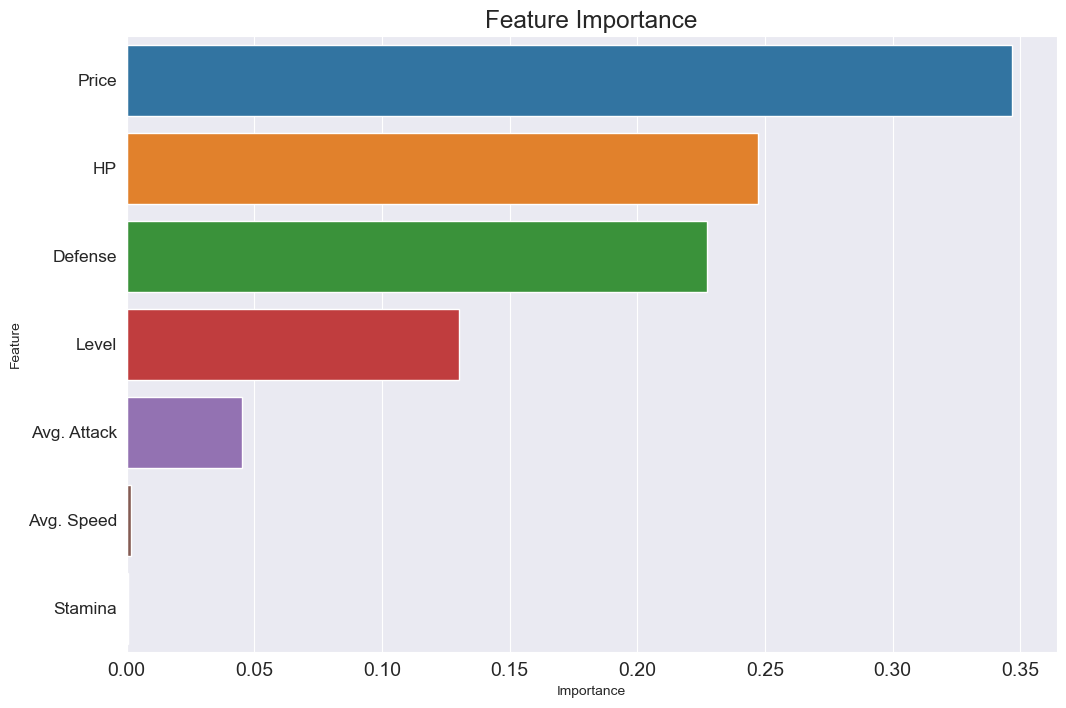

Root Mean Squared Error: 0.07013871074846924
R-squared: 0.9020373465972283


In [29]:
def plot_feature_importances(model, feat_names):
    """ plots feature importances from a RandomForestRegressor model

    Args:
        model (RandomForestRegressor): trained RandomForestRegressor model
        feat_names (list): list of feature names
    
    Returns:
        null: plotting 
    """
    
    # get feature importance (take top 7)
    importance = model.feature_importances_[:7]

    # create a dataframe for plotting
    feature_importance = pd.DataFrame({
        'Feature': feat_names[:7],
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance', fontsize=17.5)
    plt.xlabel('Importance')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12.5)
    plt.ylabel('Feature')
    plt.savefig('feat_imp.png')
    plt.show()
    

def random_forest_regrssor(data_df):
    """ creates a random forest regressor and fits the data to predict the combat power of each pal
    
    Args:
        data_df (pandas dataframe): a pandas dataframe of all the data for each pal
        
    Returns:
        r_2 (float): the r^2 value of the model
        mse (float): the mean squared error of the model
    """
    
    # normalize the combat power column
    max_v = data_df['CP'].max()
    min_v = data_df['CP'].min()
    data_df['Normalized CP'] = (data_df['CP'] - min_v) / (max_v - min_v)


    # encode categorical variables
    df_encoded = pd.get_dummies(data_df, columns=['Rarity', 'Element Type'], drop_first=True)

    # define x features  and y target (drop un-needed columns)
    x = df_encoded.drop(columns=['Name', 'CP', 'Normalized CP', 'Abilities'])  
    y = df_encoded['Normalized CP']
    
    # create the random forest regressor
    rfr = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=500)

    # create a kfold for a 10-fold cross validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    # set y_pred
    y_pred = np.empty_like(y)
    
    # perform cross-validation
    for train_idx, test_idx in kfold.split(x):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
        rfr.fit(x_train, y_train)
        y_pred[test_idx] = rfr.predict(x_test)
    
    # plot feature importance
    feature_names = x.columns
    plot_feature_importances(rfr, feature_names)
    
    # evaluate the model
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    # output the performance
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")
    
random_forest_regrssor(pals_df)

 ##### Analysis:
An R-Squared value of roughly 0.90 tells us that 90% of our variance is explained, which is good considering the type of model and that cross-validation has been applied. Our root mean squared error tells us that on average we were off by 0.07 combat power units, which is fairly good considering combat power ranges from 0 to 1. The price and health points tended to dictate most of the predictions, which aligns with our scatterplot matrix correlation.

#### Model 2: PCA to Find Element Type Distinctions

We have chosen to use a PCA because we believe that if certain Element Types have distinctions/advantages, each Element Type would cluster. PCA is good for understanding the data and identifying the key features that explain the most variance. Explained variance, loading, and biplots will help us determine how well the PCA captures these distinctions and which features contribute most to the differences.

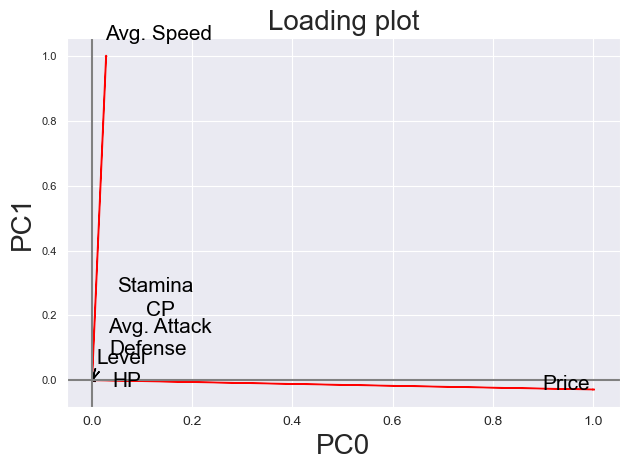

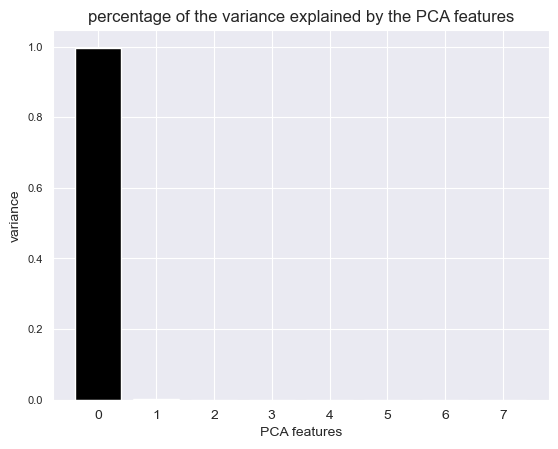

Explained Variance [9.96651678e-01 2.99842558e-03 2.20116042e-04 9.60416579e-05
 1.68512801e-05 1.64606426e-05 4.27242055e-07 6.15631806e-36]
Explained Variance Cumulative [0.99665168 0.9996501  0.99987022 0.99996626 0.99998311 0.99999957
 1.         1.        ]


In [30]:
def loading_plot(dfx):
    """ creates a loading plot matrix examining the comparison and impact of certain features on PCs
    
    Args:
        dfx (pandas dataframe): a pandas dataframe of all the numerical data for a pal
        
    Returns:
        null: plotting
    """
    #fitting
    pca = PCA(whiten = True)
    y = pca.fit_transform(dfx.values)
    
    #plotting
    for i, feature in enumerate(dfx.columns):
        if feature == 'Avg. Speed' or feature == 'Price':
            plt.arrow(0,0, pca.components_[0,i], pca.components_[1,i], color = 'r')
            plt.text(pca.components_[0,i]*.9, pca.components_[1,i]*1.05, feature, 
            color = 'k', fontsize=15)
            test = []
        else: #Better for readability 
            plt.arrow(0,0, pca.components_[0,i], pca.components_[1,i], edgecolor = 'black', width = .0005)
            plt.text(pca.components_[0,i]*8, pca.components_[1,i]*8, feature, 
                     color = 'k', fontsize=15)
    
    #plot details
    plt.title('Loading plot', fontsize=20)
    plt.xlabel("PC0", fontsize=20)
    plt.ylabel('PC1', fontsize=20)
    plt.axhline(0, color = 'grey')
    plt.axvline(0, color = 'grey')
    plt.tight_layout()
    #plt.savefig('PCAloading_final.png')
    plt.show()


def cumsumplot(dfx):
    """ creates a bar plot examining the cumulative explained variance
    
    Args:
        dfx (pandas dataframe): a pandas dataframe of all the numerical data for a pal
        
    Returns:
        null: plotting
    """
    
    #fitting
    pca = PCA(whiten = True)
    y = pca.fit_transform(dfx.values)
    
    #plot
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color = 'k')
    plt.xlabel('PCA features')
    plt.ylabel('variance')
    plt.title('percentage of the variance explained by the PCA features')
    plt.show()


def pca_elt_dist(df):
    """ creates graphs to help analyze the PCA model, as well as Explained Variance data
    
    Args:
        df (pandas dataframe): a pandas dataframe of all the data for pal
        
    Returns:
        null: plotting
    """
    
    #Create a copy to preserve original data
    pals = copy(df)
    
    #Select only numerical categories
    dfx = df.select_dtypes(include=np.number)
    
    #fit
    pca = PCA(whiten = True)
    x_pca = pca.fit_transform(dfx.values)

    pals['pca0'] = x_pca[:, 0]
    pals['pca1'] = x_pca[:, 1]
    
    #plotting
    fig = px.scatter(pals, x = 'pca0', y = 'pca1', hover_data = ['Name', 'Rarity'], 
                 color = 'Element Type', title = 'Element Type Distribution', )
    fig.update_layout( yaxis = dict( tickfont = dict(size=15), titlefont = dict(size=20)), xaxis = dict( tickfont = dict(size=15), titlefont = dict(size=20)))
    #fig.update_yaxes(dict( tickfont = dict(size=30)))
    #fig.update_xaxes(tickfont_size=30)
    
    
    #fig.write_image("PCAbiPlot.png") 
    fig.show()

    loading_plot(dfx)
    cumsumplot(dfx)
    
    #Printing explain variance
    print('Explained Variance' , pca.explained_variance_ratio_)
    print('Explained Variance Cumulative', pca.explained_variance_ratio_.cumsum())


#call function
pca_elt_dist(df_filtered)

##### Analysis:

One would select the number of components by analyzing the explained variance, and choosing the amount to cover at least 90% variance, the cumulative explained variance tells us with just one PC, 99.6% of our variance is explained, which would mean other components do not significantly contribute to variance and are likely highly correlated/redundant. We can deduce that Element Types are not very distinctive, which we can also tell since there is no clear grouping/clustering in the bi-plot. The loading plot shows features that influence the principle components, we can observe that price mainly contributes to PC0 but little to PC1, where avg speed is the opposite, as it primarily contributes to PC1 and little to PC0. All other features have little contribution to either.

## Discussion

#### Conclusion

Owens Conclusions:

- The conclusions of our visualizations and models tend to align with our assumptions. The dragon and dark element types tend to be better on average for a multitude of features, which would help us conclude that they are indeed the best element types. However, we discovered that element types do not seem to have distinctive features. The PCA model showed little variance in the features , meaning the values of each feature are relatively close. Observed in the Bar plots, only Dragons Speed had a significantly larger average than the rest. Observed in the Box Plots, each feature range overlaps a lot with others (Stamina has many 'outliers'.
- Both the scatterplot matrix and random forest regression showed us that the health points and price of a pal are heavy indicators of their combat power. Still, we would've expected the level feature to be more than the 4th-ranked importance feature. The heat map also supports that HP and Price are indicators of Combat Power, and Defense and Level, are still very correlated to Combat Power.

Kerbs Conclusions:
- In model 2 we used a PCA model to better understand the relationship between features and Element type. We concluded that there are little distinctions between certain pal Element Types. We evaluated the model using explained variance and analysis of a bi-plot, the explained variance showed that the ideal amount of PCs would be 1 since its values represent the percent of variance explained, meaning most variance is determined by this one component. We analyzed the bi-plot and concluded there were no obvious signs of clustering/grouping, meaning that distinct Element types do not necessarily have distinct features that could be used to identify them. A potential way to improve this analysis would be to have a larger data set or to use different features like items dropped or workability to distinguish element types. 
- In model 1 we used a Random Forest Regressor model to predict Combat Power. We concluded that yes, certain features do impact a Pals combat power. Price and health points are features that dictated most of the predictions. We evaluated the model using Root Mean Squared Error (about 0.07) and R-Squared (~90%), meaning that 90% of the variance is explained and that on average our predictions were off by about 0.07 combat power. The scatter plot and heat map also support this as the scatter plot visualizes the linearity between HP, Price, Level, and CP. The heat map visualizes the correlation of features, showing that HP, Price, Defense, and Level are the most important features in determining CP. A potential way to improve this analysis is to use more features, for example, abilities, which have multiple values for each ability (level, power, cooldown, range) which could be analyzed or re-defining combat power. 


#### Potentials
For future work that we could consider, we could possibly find further features and then determine the best pals in the entire game to get. We could also find a different site to pull data from to compare what data is given from two unique pal databases.


#### Contribution
- Introduction: Owen
- Data: Owen
- Web Scraping and Cleaning: Owen
- Visualization 1: Owen
- Visualization 2: Owen
- Visualization 3: Kerbs
- Visualization 4: Kerbs
- Model 1: Owen
- Model 2: Kerbs
- Discussion: Both

2 Other Interesting Presentations - Owen

- I liked Group 5s project on finding out which features impacted a pals rarity as well as how attributes and health points are related. These were two questions our group didn't consider, and I think they had great plots (i.e. their random forest classifier confusion matrix for predicting rarity, and their rainbow box plot for their comparison of pal attributes and health points) which answered both these questions well. 
- I also liked Group 7s analysis on if a pal's stats can predict what type they are. I felt this is essentially the inverse of what we were looking at (what element types have better stats). It was interesting to see that their decision tree predicted only 21% of element types correctly, which tells me that there is really no distinctions to a multitude of element types.

2 Other Interesting Presentations - Kerbs

Group 3:
- The rarity distribution prediction was insightful. The bar plot revealed that only certain element types can be legendary. This made me think about my own project, and how perhaps rarity could be a way to find distinctions in element types.
- The use of a heat map to show the average price seemed odd to me; I think a bar plot would have been better and simpler for that purpose.
- The decision tree was a good model for prediction, and I appreciated the random forest confusion matrices. It makes sense that rare and epic, the two middle rarities, often get confused.

Group 2: Rarity and Relation to Features
- The first visualization, a scatter plot, was interesting as it showed how features could be balance out (If you have high attack youd probs have low defense or something along those lines).
- The second visualization, a box plot, was a good choice, as it clearly demonstrated the distribution and the pattern that HP increases with rarity.
- In the third visualization, it was a good decision to exclude legendary types. I wonder if in my project, if excluding them would have impacted our data and made the level a more significant factor.
- In the second model, it was intriguing that this group also had the most failed predictions between epic and rare rarities.
- I would have liked to see different models used, maybe another could have provided better prediction accuracy.